# Topological edge states in a photonic crystal

By engineering the periodic structure of photonic crystals, protected edge or surface states where light travels along boundaries without being scattered by defects or sharp bends can be created. This topological protection enables robust, loss-resistant light transport, making topological photonic crystals promising for next-generation optical circuits, communications, and quantum technologies. 

This notebook showcases the simulation of a topological photonic crystal that supports chiral edge states, reproducing the design proposed by `Sabyasachi Barik et al., A topological quantum optics interface. Science 359, 666-668(2018).` [DOI: 10.1126/science.aaq0327](https://www.science.org/doi/10.1126/science.aaq0327). The paper presents a significant advancement in integrating quantum emitters with topological photonic structures. The authors demonstrate a strong interface between single quantum emitters and topological photonic states, creating robust counterpropagating edge states at the boundary of two distinct topological photonic crystals. This approach enables chiral emission of a quantum emitter into these modes and establishes their robustness against sharp bends, potentially paving the way for quantum optics devices with built-in protection. 

<img src="img/topological_phc.png" width="400" alt="Schematic of the topological photonic crystal">

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## Simulation Setup

First define the wavelength range of interest.

In [2]:
# define frequency and wavelength range of interest
lda0 = 0.92
freq0 = td.C_0 / lda0

ldas = np.linspace(0.84, 1.0, 101)
freqs = td.C_0 / ldas

fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # frequency width of the source

Define geometric parameters for the photonic crystal. 

In [3]:
s = 0.14  # edge length of the equilateral triangle
a0 = 0.445  # lattice constant
h = 0.16  # slab thickness
Nx = 20  # number of unit cells in the x direction
Ny = 16  # number of unit cells in the y direction

The photonic crystal consists of unit cells with slightly different geometries at different lattice sites. To create such a structure, we first define a function to create the unit cell geometry at a given center position. 

In [4]:
def make_unit_cell(
    s: float, a0: float, r: float, h: float, x0: float, y0: float
) -> td.GeometryGroup:
    """
    Construct a unit cell geometry composed of equilateral triangles
    arranged around a central point (x0, y0).

    Parameters
    ----------
    s : float
        Edge length of each equilateral triangle.
    a0 : float
        Lattice constant (not directly used here but possibly for future extension).
    r : float
        Radial distance from the center of the unit cell to the centroid of each triangle.
    h: float
        Thickness of the slab.
    x0 : float
        X-coordinate of the unit cell's center.
    y0 : float
        Y-coordinate of the unit cell's center.

    Returns
    -------
    triangles : td.GeometryGroup
        The unit cell geometry
    """
    # define vertices of an equilateral triangle, centered at the origin, with edge length s.
    vertices_0 = s * np.array(
        [
            [0.0, np.sqrt(3) / 3],  # Top vertex
            [-0.5, -np.sqrt(3) / 6],  # Bottom-left vertex
            [0.5, -np.sqrt(3) / 6],  # Bottom-right vertex
        ]
    )

    # angles at which to place triangles, spaced by 60 degrees (pi/3), covering a full circle.
    angles = np.arange(0, 2 * np.pi, np.pi / 3)

    triangles = []

    for angle in angles:
        # create a 2D rotation matrix to rotate the triangle by (angle + 90 degrees)
        R = np.array(
            [
                [np.cos(angle + np.pi / 2), -np.sin(angle + np.pi / 2)],
                [np.sin(angle + np.pi / 2), np.cos(angle + np.pi / 2)],
            ]
        )

        # rotate the triangle vertices about the origin
        verts_rot = vertices_0 @ R.T

        # compute the center position for this triangle, offset from (x0, y0) by distance r
        centre = np.array([r * np.cos(angle) + x0, r * np.sin(angle) + y0])

        # translate the rotated vertices to the correct position
        verts = verts_rot + centre

        triangles.append(
            td.PolySlab(
                vertices=verts,
                axis=2,
                slab_bounds=(-h / 2, h / 2),
            )
        )

    return td.GeometryGroup(geometries=triangles)

To verify if the function works properly, create a dummy unit cell and visualize it. 

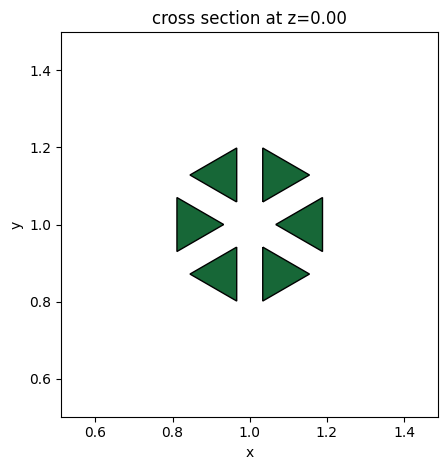

In [5]:
r = a0 / 3

triangles = make_unit_cell(s, a0, r, h, x0=1, y0=1)
triangles.plot(z=0)
plt.show()

Next we create another function to calculate the centers of the lattice sites in the triangular lattice. We will also separate the sites into the top half and the bottom half since they need to have a different unit cell geometry to induce the chiral edge state.

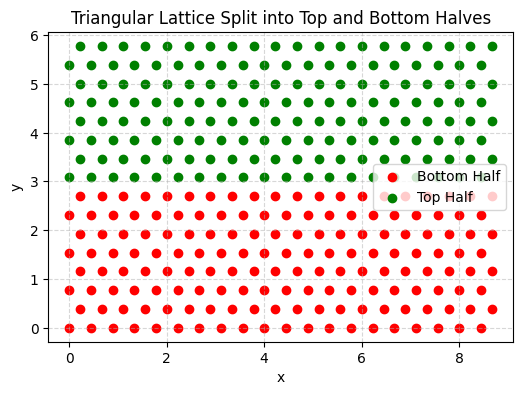

In [6]:
def generate_triangle_lattice(a0: float, Nx: int, Ny: int) -> list[tuple[float, float]]:
    """
    Generate (x, y) coordinates for a two-dimensional triangular lattice.

    Parameters
    ----------
    a0 : float
        Lattice constant (distance between nearest neighbor sites).
    Nx : int
        Number of lattice sites along the x-direction.
    Ny : int
        Number of lattice sites along the y-direction.

    Returns
    -------
    coords : list[tuple[float, float]]
        List of (x, y) coordinate tuples for each lattice site.
    """

    coords = []

    for j in range(Ny):
        for i in range(Nx):
            # shift every other row by a0/2 to create a triangular lattice pattern
            x = a0 * (i + 0.5 * (j % 2))
            # set vertical spacing between rows
            y = a0 * (np.sqrt(3) / 2) * j
            coords.append((x, y))

    return coords


lattice_sites = generate_triangle_lattice(a0, Nx, Ny)

lattice_sites_sorted = sorted(lattice_sites, key=lambda xy: xy[1])

# split into bottom half and top half
N_total = len(lattice_sites_sorted)
N_half = N_total // 2

bottom_sites = lattice_sites_sorted[:N_half]
top_sites = lattice_sites_sorted[N_half:]

x_bottom, y_bottom = zip(*bottom_sites)
x_top, y_top = zip(*top_sites)

plt.figure(figsize=(6, 6))
plt.scatter(x_bottom, y_bottom, color="red", label="Bottom Half")
plt.scatter(x_top, y_top, color="green", label="Top Half")
plt.gca().set_aspect("equal")
plt.title("Triangular Lattice Split into Top and Bottom Halves")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

Similarly, we can create the actual unit cell structures and visualize them with the color denoting if they are on the top half or bottom half. The unit cells on the top have `r = 0.94 * a0 / 3` while the unit cells on the bottom have `r = 1.05 * a0 / 3`, as discussed in the [reference](https://www.science.org/doi/10.1126/science.aaq0327). The top and bottom regions have different topological properties and as a result, chiral edge states are supported at the interface.

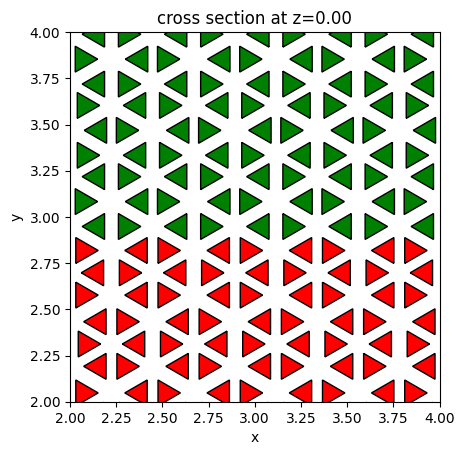

In [7]:
fig, ax = plt.subplots(1)

r = 0.94 * a0 / 3

lower_half_geometry = 0
for site in bottom_sites:
    lower_half_geometry += make_unit_cell(s, a0, r, h, x0=site[0], y0=site[1])

r = 1.05 * a0 / 3
top_half_geometry = 0
for site in top_sites:
    top_half_geometry += make_unit_cell(s, a0, r, h, x0=site[0], y0=site[1])

hole_geometry = lower_half_geometry + top_half_geometry
lower_half_geometry.plot(z=0, ax=ax, facecolor="red")
top_half_geometry.plot(z=0, ax=ax, facecolor="green")

ax.set_xlim((2, 4))
ax.set_ylim((2, 4))

plt.show()

To perform the FDTD simulation, we need to define the material property, sources, and monitors. 

The slab is made of GaAs. We will directly use our [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html) to define its optical property. 

For the source, we want to create a circularly polarized [PointDipoles](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PointDipole.html), which can be defined by two cross-polarized dipoles with a 90-degree phase shift. For the monitor, we will add a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) to visualize the unidirectional propagation of the edge mode. Additionally, we will also use two [FluxMonitors](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FluxMonitor.html) to measure the transmission power to the left and right. This will help us determine the topological band gap.

In [8]:
GaAs = td.material_library["GaAs"][
    "Palik_Lossy"
]  # use the material property from the built-in library

# create the GaAs slab structure
slab = td.Structure(geometry=td.Box(center=(0, 0, 0), size=(td.inf, td.inf, h)), medium=GaAs)

# create the air hole structures
holes = td.Structure(geometry=hole_geometry, medium=td.Medium())

# Place the dipole source in the center of the "shrunken" site at the interface
dipole_pos_x = (Nx // 2 - 1 / 2) * a0
dipole_pos_y = (Ny // 2 - 1) * a0 * np.sqrt(3) / 2

# create a dipole polarized in the x direction
dipole_source_x = td.PointDipole(
    center=(dipole_pos_x, dipole_pos_y, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    polarization="Ex",
)

# create a dipole polarized in the y direction with a pi/2 phase
dipole_source_y = td.PointDipole(
    center=(dipole_pos_x, dipole_pos_y, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth, phase=np.pi / 2),
    polarization="Ey",
)

# create a field monitor to visualize the field distribution
field_monitor = td.FieldMonitor(size=(td.inf, td.inf, 0), freqs=[freq0], name="field")

flux_monitor_left = td.FluxMonitor(
    size=(0, 4, 4), center=(Nx * a0 / 2 - 3, 2.6, 0), freqs=freqs, name="flux_left"
)

flux_monitor_right = td.FluxMonitor(
    size=(0, 4, 4), center=(Nx * a0 / 2 + 3, 2.6, 0), freqs=freqs, name="flux_right"
)

Create the [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) and visualize it to ensure the sources and monitors are set up correctly. In this case, we use the absorber boundary in the x and y directions since the photonic crystal structure is not translationally invariant, which might cause the simulation to diverge if PML is used.   

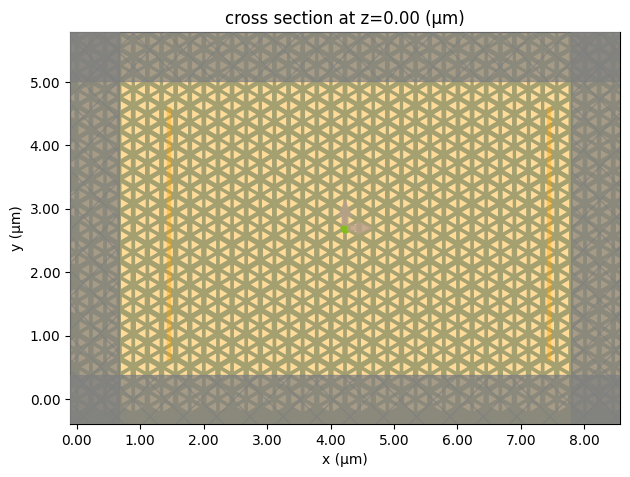

In [9]:
buffer = 0.8 * lda0  # buffer spacing

# create the simulation
sim = td.Simulation(
    center=dipole_source_x.center,
    size=((Nx - 4) * a0, (Ny - 4) * np.sqrt(3) * a0 / 2, h + 2 * buffer),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20),
    run_time=2e-12,
    structures=[slab, holes],
    sources=[dipole_source_x, dipole_source_y],
    monitors=[field_monitor, flux_monitor_left, flux_monitor_right],
    symmetry=(0, 0, 1),
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.absorber(num_layers=60),
        y=td.Boundary.absorber(num_layers=60),
        z=td.Boundary.pml(),
    ),
)

sim.plot(z=0)
plt.show()

Run the simulation in the cloud. 

In [10]:
sim_data = web.run(simulation=sim, task_name="RCP")

13:26:45 CEST Created task 'RCP' with task_id                                   
              'fdve-10f91391-0d82-4828-8e8b-92f901b96a11' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=502521;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10f91391-0d82-4828-8e8b-92f901b96a11\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=124858;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10f91391-0d82-4828-8e8b-92f901b96a11\taskId]8;;\]8;id=502521;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10f91391-0d82-4828-8e8b-92f901b96a11\=]8;;\]8;id=408780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10f91391-0d82-4828-8e8b-92f901b96a11\fdve]8;;\]8;id=502521;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10f91391-0d82-4828-8e8b-92f901b96a11\-10f91391-0d]8;;\
              ]8;id=502521;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10f91391-0d82-4828-8e8b-92f901b96a11\82-4828-8e8b-92f901b96a11']8;;\.

              Task folder: ]8;id=267952;https://tidy3d.simulation.cloud/folders/9b36e144-ddb6-41f8-8dd8-30b62b26a870\'default']8;;\.

Output()

13:26:50 CEST Maximum FlexCredit cost: 0.615. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:26:51 CEST status = success

Output()

13:27:00 CEST loading simulation from simulation_data.hdf5

## Result Visualization

First let's plot the field intensity distribution to observe the unidirectional propagation of the chiral edge mode at 920 nm. 

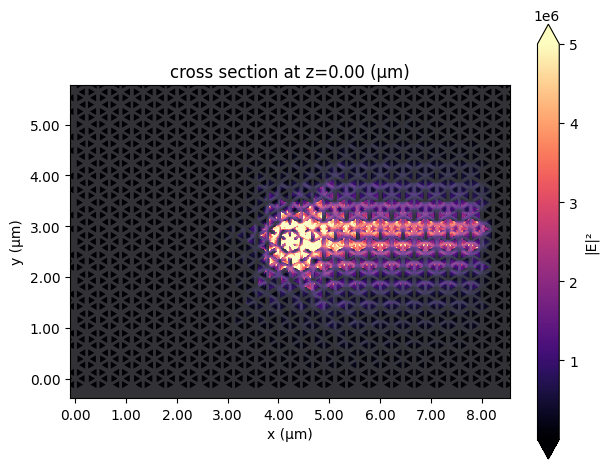

In [11]:
# plot field monitor data
sim_data.plot_field(
    field_monitor_name="field", field_name="E", val="abs^2", eps_alpha=0.2, vmax=5e6
)
plt.show()

We can infer the frequency range of the topological band gap from the region of frequencies in which propagation to the left is strongly suppressed, which appears to be around 900 to 950 nm.

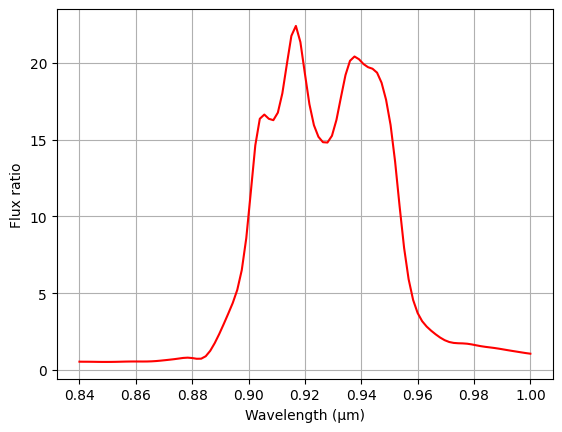

In [12]:
# Extract flux data from simulation results
flux_left = np.abs(sim_data["flux_left"].flux)
flux_right = np.abs(sim_data["flux_right"].flux)

plt.plot(ldas, flux_right / flux_left, color="red")
plt.xlabel("Wavelength (μm)")
plt.ylabel("Flux ratio")
plt.grid(True)
plt.show()

## Final Remarks

In Fig. 1C and D, the band structures of the TE modes of the two photonic crystals are shown. In this notebook we did not explicitly calculate the band structures but they can be calculated by using the approach introduced in the tutorial [here](https://www.flexcompute.com/tidy3d/examples/notebooks/Bandstructure/).

We only simulated a right circularly polarized dipole source in this notebook, which couples to the right propagating mode. Similarly a left circularly polarized source can be simulated by adjusting the phase difference to -pi/2. 